# Testing DEMV on _Wine Quality_ Dataset

- Label: `quality`
- Positive label: `quality=6`
- Unprivileged group: `alcohol=0 (<=10) & type=1 (white)`

Source: [https://archive.ics.uci.edu/ml/datasets/wine+quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearnex import patch_sklearn

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from demv import DEMV
from utils import *

import warnings
warnings.filterwarnings('ignore')

#patch_sklearn()
sns.set_style('whitegrid')

In [2]:
def load_data():
  red = pd.read_csv('data2/winequality-red.csv', sep=';')
  red['type'] = 0
  white = pd.read_csv('data2/winequality-white.csv', sep=';')
  white['type'] = 1
  data = red.append(white)
  data.drop(data[(data['quality']==3)|(data['quality']==9)].index, inplace=True)
  data.loc[data['alcohol'] <= 10, 'alcohol'] = 0
  data.loc[(data['alcohol'] > 10) & (data['alcohol'] != 0), 'alcohol'] = 1
  return data

In [3]:
data = load_data()

In [4]:
label = 'quality'
sensitive_variables = ['alcohol', 'type']
protected_group = {'alcohol': 0, 'type': 1}
positive_label = 6

In [5]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression(n_jobs=-1))
])

## Biased dataset

In [6]:
model, bias_metrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_variables,positive_label=positive_label)

In [7]:
print_metrics(bias_metrics)

Statistical parity:  -0.315  +-  0.032
Disparate impact:  0.544  +-  0.043
Zero one loss:  0.154  +-  0.028
F1 score:  0.514  +-  0.021
Accuracy score:  0.543  +-  0.021


## DEMV dataset

In [8]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [9]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_variables, positive_label=positive_label, debiaser=demv)

In [10]:
print_metrics(demv_metrics)

Statistical parity:  -0.107  +-  0.049
Disparate impact:  0.855  +-  0.06
Zero one loss:  0.12  +-  0.051
F1 score:  0.45  +-  0.017
Accuracy score:  0.501  +-  0.015


## DEMV Evaluation

In [11]:
demv.get_iters()

384

In [12]:
metrics = eval_demv(76, demv.get_iters(), data.copy(), pipeline, label,
                    protected_group, sensitive_variables, positive_label=positive_label)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing 

In [13]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [14]:
data.loc[:,"combined"] = 0
data.loc[(data['alcohol'] == 0) & (data["type"] == 1),"combined"] = 1
#Now pred has the actual values on column "y_true" and predicted values on column "contr_use"

pred.loc[:,"combined"] = 0
pred.loc[(pred['alcohol'] == 0) & (pred["type"] == 1),"combined"] = 1

pred.iloc[-20:, pred.columns.get_loc(label)] = 8

y_pred = pred[label].values
y_true = pred['y_true'].values

import tools
stats = tools.clf_metrics(y_true, y_pred)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,1323.0,1124.0,3175.0,816.0,0.5416,0.7053,0.5271,0.7659,0.2469,0.5134,0.2634,0.3013,0.0,0.0,2139.0,2447.0,308.0,0.0


In [18]:
blackboxmetrics = blackboxCVmetrics( data, label, y_true, unpriv_group, pred )


Pre-adjustment group rates are 

0
      fpr     tpr
4  0.0000  0.0714
5  0.1138  0.3824
6  0.6652  0.7642
7  0.0560  0.2784
8  0.0024  0.0000

1
      fpr     tpr
4  0.0051  0.0000
5  0.5204  0.7273
6  0.2791  0.4810
7  0.0050  0.0000
8  0.0048  0.0000


And loss is 0.4612



ValueError: could not broadcast input array from shape (4,4) into shape (5,5)

##  Plot

In [ ]:
df = prepareplots(metrics,'wine')

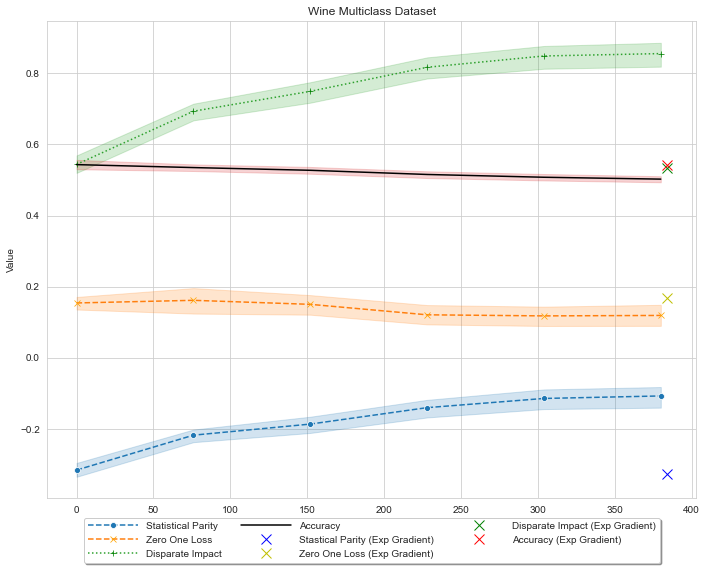

In [ ]:
points = preparepoints(blackboxmetrics, demv.get_iters())

plot_metrics_curves(df, points, 'Wine Multiclass Dataset')


In [ ]:
unprivpergentage(data,protected_group, demv.get_iters())